In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from Causal_inference import granger_causality,add_causality_dataset, generate_synthetic
from time import time
import pmdarima as pm
from tqdm import tqdm
from statsmodels.tsa.arima_model import ARMA
from TimeSeries import TimeSeries
from copy import deepcopy

In [15]:
def load_dataset(path):
    path = path
    TRAIN, train_labels = TimeSeries.load(path+'_TRAIN', "UCR")
    TEST, test_labels = TimeSeries.load(path+'_TEST', "UCR")

    return TRAIN, train_labels, TEST, test_labels

def plot(x):
    l = np.arange(x.shape[0])
    plt.plot(l, x, c='blue')
    plt.show()


def adf_test(x, pval = 0.05):
    """
    Test if the time series is stationary
    :param x: time series
    :return:
    """
    dftest = adfuller(x, autolag='AIC')
    if dftest[1] < pval:
        return True
    else:
        return False
    
def difference(x):
    m = x.shape[0]
    diff = [x[0]]
    for i in range(1,m):
        val = x[i] - x[i-1]
        diff.append(val)
    diff = np.array(diff)
    return diff

def make_stationary(x, plot = False):
    """
    Take difference until statinonary
    :param x: time series
    :return:
    """
    for it in range(10):
        diff = []
        if adf_test(x):
            return np.array(x)
        for i in range(1, len(x)):
            val = x[i] - x[i - 1]
            diff.append(val)
        x = diff

        if it == 9:
            print('Cannot be made stationary')

        if plot:
            l = np.arange(len(diff))
            plt.plot(l, x, c='blue')
            plt.show()
    return np.array(x)


def preprocess_dataset(TS):
    """
    Make each time series stationary
    :param TS: 
    :return: 
    """
    minlength = float('inf')
    newTS = [None for i in range(TS.shape[0])]
    for i in range(TS.shape[0]):
        newTS[i] = make_stationary(TS[i])
        minlength = min(minlength, len(newTS[i]))
    for i in range(TS.shape[0]):
        m = len(newTS[i])
        newTS[i] = newTS[i][(m-minlength):]
    return np.array(newTS)

def add_causality(x, y, lag):
    m = y.shape[0]
    for i in range(m-lag):
        y[i + lag] += x[i]
        
def random_walk(drift = 0, m = 128, sd = 1):
    ls = [None] * m
    ls[0] = np.random.normal(0,1)
    for i in range(1, m):
        ls[i] = ls[i-1] + drift + np.random.normal(0,sd)
    return np.array(ls)

def add_rwalk_to_db(ts, sd = 0.1):
    newts = deepcopy(ts)
    for i in range(newts.shape[0]):
        newts[i] += random_walk(m = newts.shape[1], sd = sd)
    return newts

def generate_with_rwalk(sd = 0.1):
    noisydata = np.load('ecgarimanoisy200.npy')
    plot(noisydata[1])
    for i in range(1,200, 2):
        walk = random_walk(m = 96, sd= sd)
        noisydata[i] += walk
    plot(noisydata[1])
    return noisydata
    
def add_noise(TS, sd):
    n,m  = TS.shape
    newTS = deepcopy(TS)
    for i in range(n):
        newTS[i] += np.random.normal(0, sd, m)
    return newTS

In [16]:
ts, train_labels, TEST, test_labels = load_dataset('UCR2018/Fish/Fish')

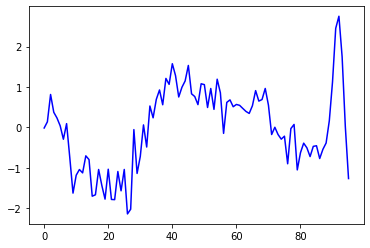

In [22]:
noisydata = np.load('ecgarimanoisy200.npy')
plot(noisydata[3])

for i in range(1,200, 2):
    noisydata[i] += random_walk(m = 96, sd= 0.1)

In [21]:
import sklearn
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

In [57]:
f = np.array([1,2,3])
g = np.array([4,5,6])

f = np.vstack((f, g))
print(f)

[[1 2 3]
 [4 5 6]]


(96, 2)
(96, 1)
(96, 2)
(96, 3)
(96, 4)
(96, 4)


(<Figure size 432x288 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f83b41e9100>,
       dtype=object))

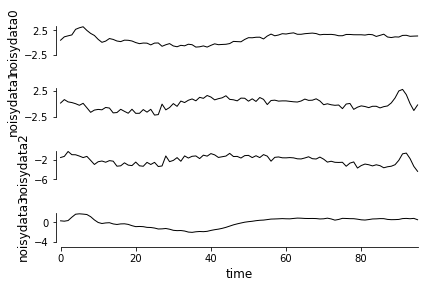

In [60]:
sample_set_data = np.empty(shape=[96, 1])
var_names = []
for i in range(5):
    n = noisydata[i].reshape(len(noisydata[i]), 1)
    name = f"noisydata{i}"
    var_names.append(name)
    if i ==1:
        sample_set_data = n
    else:
        sample_set_data = np.hstack((sample_set_data, n))
# T = len(noisydata[3])
# data, true_parents_neighbors = pp.var_process(sample_set_data, T=T)

# n = noisydata[3].reshape(len(noisydata[3]), 1)
df = pp.DataFrame(sample_set_data, datatime = np.arange(len(noisydata[3])),var_names=var_names)
tp.plot_timeseries(df)


1: PCMCI

initialize pcmi object

In [61]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=df, 
    cond_ind_test=parcorr,
    verbosity=1)

Unconditional Dependencies, Lagged Correlations

Choosing the tau_max


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


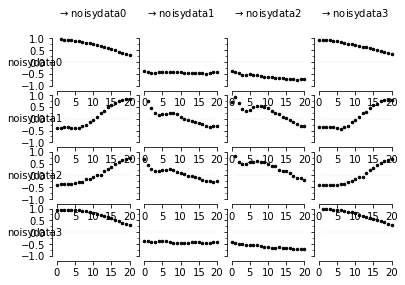

In [63]:
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

In [64]:
pcmci.verbosity = 1
results = pcmci.run_pcmci(tau_max=8, pc_alpha=None)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable noisydata0 has 6 link(s):
    [pc_alpha = 0.4]
        (noisydata3 -1): max_pval = 0.00003, min_val =  0.462
        (noisydata0 -1): max_pval = 0.00409, min_val =  0.328
        (noisydata0 -3): max_pval = 0.06310, min_val =  0.211
        (noisydata1 -2): max_pval = 0.19752, min_val =  0.153
        (noisydata2 -6): max_pval = 0.33010, min_val =  0.110
        (noisydata1 -3): max_pval = 0.38071, min_val = -0.101

    Variable noisydata1 has 2 link(s):
    [pc_alpha = 0.4]
        (noisydata1 -1): max_pval = 0.00000, min_val =  0.595
        (noisydata3 -8): max_pval = 0.37510, min_val = -0.102

    Variable noisydata2 has 9 link(s):
    [pc_alpha = 0.5]
        (noisydata1 -1): max_pval = 0.00000, min_val =  0.700
        (n

p-values

correlations

In [65]:

print("p-values")
print (results['p_matrix'].round(3))
print("MCI partial correlations")
print (results['val_matrix'].round(2))

p-values
[[[1.    0.    0.007 0.055 0.187 0.414 0.001 0.174 0.085]
  [0.551 0.617 0.79  0.176 0.121 0.885 0.844 0.21  0.687]
  [0.764 0.325 0.436 0.133 0.461 0.335 0.961 0.986 0.207]
  [0.707 0.121 0.189 0.368 0.588 0.813 0.035 0.058 0.806]]

 [[0.551 0.703 0.005 0.732 0.15  0.32  0.098 0.338 0.697]
  [1.    0.    0.763 0.104 0.024 0.053 0.451 0.993 0.204]
  [0.125 0.    0.    0.225 0.755 0.497 0.523 0.42  0.86 ]
  [0.958 0.222 0.803 0.813 0.145 0.919 0.638 0.082 0.151]]

 [[0.764 0.785 0.674 0.194 0.483 0.768 0.596 0.577 0.522]
  [0.125 0.434 0.039 0.654 0.3   0.238 0.583 0.696 0.149]
  [1.    0.    0.493 0.88  0.479 0.701 0.799 0.474 0.287]
  [0.365 0.486 0.405 0.445 0.675 0.377 0.577 0.123 0.413]]

 [[0.707 0.002 0.387 0.395 0.191 0.923 0.518 0.492 0.662]
  [0.958 0.897 0.988 0.585 0.214 0.772 0.052 0.893 0.866]
  [0.365 0.605 0.689 0.459 0.816 0.692 0.333 0.324 0.828]
  [1.    0.    0.    0.    0.118 0.171 0.898 0.426 0.164]]]
MCI partial correlations
[[[ 0.    0.44 -0.32  0.23 -0.

In [66]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=8, fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable noisydata0 has 1 link(s):
        (noisydata0 -1): pval = 0.00012 | qval = 0.00186 | val =  0.444

    Variable noisydata1 has 1 link(s):
        (noisydata1 -1): pval = 0.00000 | qval = 0.00000 | val =  0.577

    Variable noisydata2 has 3 link(s):
        (noisydata1 -1): pval = 0.00000 | qval = 0.00000 | val =  0.983
        (noisydata1 -2): pval = 0.00000 | qval = 0.00000 | val = -0.770
        (noisydata2 -1): pval = 0.00000 | qval = 0.00000 | val =  0.658

    Variable noisydata3 has 3 link(s):
        (noisydata3 -1): pval = 0.00000 | qval = 0.00000 | val =  0.804
        (noisydata3 -2): pval = 0.00000 | qval = 0.00001 | val = -0.585
        (noisydata3 -3): pval = 0.00000 | qval = 0.00002 | val =  0.565


links occuring at multiple lags between two variables?

In [69]:
link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

AttributeError: 'Polygon' object has no attribute 'clear'

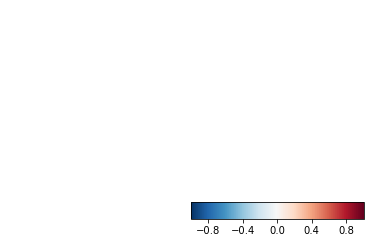

In [70]:
# tp.plot_graph(
#     val_matrix=results['val_matrix'],
#     link_matrix=link_matrix,
#     var_names=var_names,
#     link_colorbar_label='cross-MCI',
#     node_colorbar_label='auto-MCI',
#     ); plt.show()

2: PCMCI-plus

In [71]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=df, 
    cond_ind_test=parcorr,
    verbosity=1)


##
## Running Tigramite BivCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 10


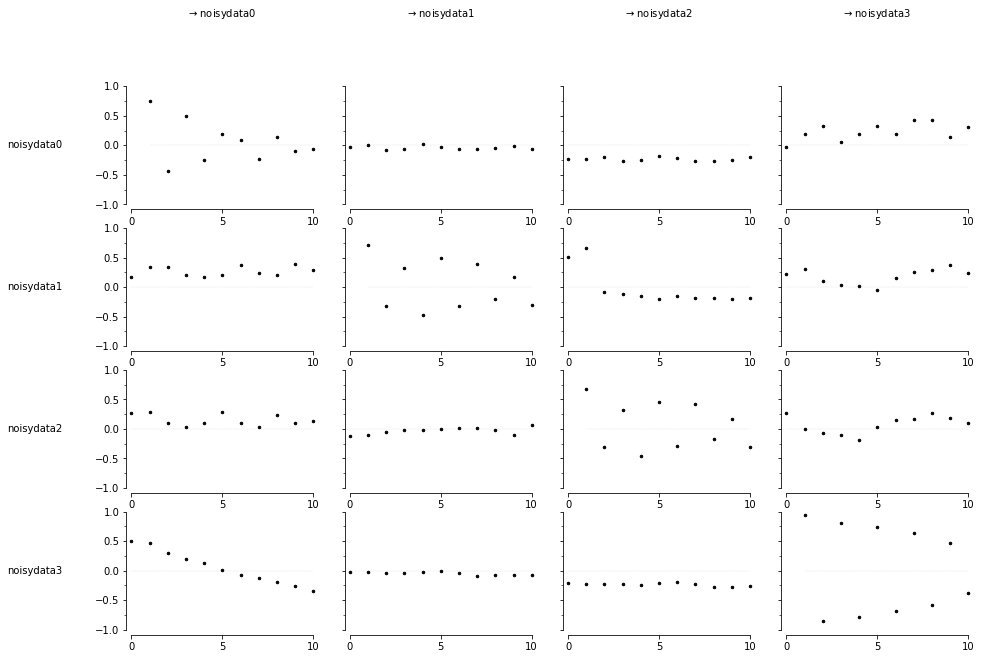

In [72]:
correlations = pcmci.run_bivci(tau_max=10, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, 
                                   setup_args={'var_names':var_names, 'figsize':(15, 10),
                                    'x_base':5, 'y_base':.5})

In [73]:
tau_max = 3
pc_alpha = 0.01
pcmci.verbosity = 2

results = pcmci.run_pcmciplus(tau_min=0, tau_max=tau_max, pc_alpha=pc_alpha)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Variable noisydata0

Iterating through pc_alpha = [0.01]:

# pc_alpha = 0.01 (1/1):

Testing condition sets of dimension 0:

    Link (noisydata0 -1) --> noisydata0 (1/12):
    Subset 0: () gives pval = 0.00000 / val =  0.956
    No conditions of dimension 0 left.

    Link (noisydata0 -2) --> noisydata0 (2/12):
    Subset 0: () gives pval = 0.00000 / val =  0.904
    No conditions of dimension 0 left.

    Link (noisydata0 -3) --> noisydata0 (3/12):
    Subset 0: () gives pval = 0.00000 / val =  0.860
    No conditions of dimension 0 left.

    Link (noisydata1 -1) --> noisydata0 (4/12):
    Subset 0: () gives pval = 0.37007 / val =  0.096
    Non-significance detected.

    Link (noisydata1 -2) --> noisydata0 (5/12):
    Subset 0: () gives pval = 0.07481 / val =  0.189
    Non-significance detected.


In [74]:
print("Graph")
print (results['graph'])
print("Adjacency MCI partial correlations")
print (results['val_matrix'].round(2))
print("Adjacency p-values")
print (results['p_matrix'].round(3))

Graph
[[['' '-->' '' '']
  ['' '' '' '']
  ['' '' '' '']
  ['' '' '' '']]

 [['' '' '' '']
  ['' '-->' '' '']
  ['' '-->' '-->' '']
  ['' '' '' '']]

 [['' '' '' '']
  ['' '' '' '']
  ['' '-->' '' '']
  ['' '' '' '']]

 [['' '-->' '' '']
  ['' '' '' '']
  ['' '' '' '']
  ['' '-->' '-->' '-->']]]
Adjacency MCI partial correlations
[[[ 0.    0.51 -0.06 -0.15]
  [ 0.05 -0.05 -0.13 -0.18]
  [-0.03 -0.18 -0.23 -0.03]
  [ 0.19 -0.17  0.11  0.03]]

 [[ 0.05  0.1   0.19  0.23]
  [ 0.    0.61  0.05  0.14]
  [-0.15  0.98 -0.95 -0.09]
  [ 0.13  0.09  0.17  0.23]]

 [[-0.03 -0.03  0.03  0.06]
  [-0.15 -0.04  0.06 -0.07]
  [ 0.    0.7   0.01  0.14]
  [-0.06 -0.08 -0.01  0.04]]

 [[ 0.19  0.54 -0.24 -0.  ]
  [ 0.13 -0.07 -0.13 -0.19]
  [-0.06 -0.22 -0.27 -0.23]
  [ 0.    0.9  -0.72  0.6 ]]]
Adjacency p-values
[[[1.    0.    0.595 0.166]
  [0.648 0.64  0.219 0.084]
  [0.81  0.084 0.031 0.795]
  [0.076 0.111 0.319 0.747]]

 [[0.648 0.37  0.075 0.029]
  [1.    0.    0.633 0.195]
  [0.174 0.    0.    0.

In [75]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh',
                                                  exclude_contemporaneous=False)

In [76]:
link_matrix = results['graph']

AttributeError: 'Polygon' object has no attribute 'clear'

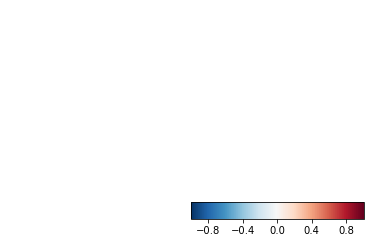

In [77]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI (edges)',
    node_colorbar_label='auto-MCI (nodes)',
    ); plt.show()

AttributeError: 'Polygon' object has no attribute 'clear'

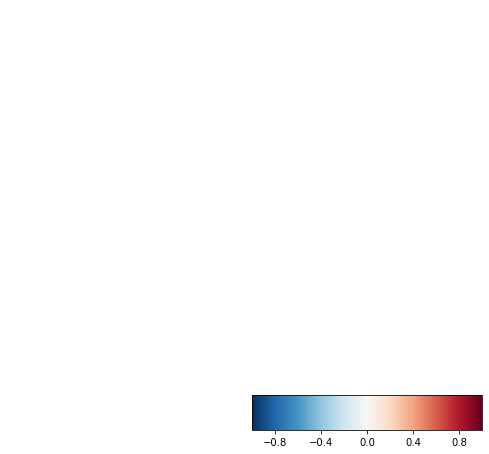

In [78]:
# Plot time series graph
tp.plot_time_series_graph(
    figsize=(8, 8),
    node_size=0.05,
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()